## Bayesian estimates of (Mr, [Fe/H], Ar) using SDSS colors and TRILEGAL priors

### speed: from 0.1-0.2 sec/star for full locus resolution to 10 millisec for sparse locus

### (with known Ar: 2D version runs in 4 milisec/star)

In [1]:
%matplotlib inline
import sys
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde
# from scipy import interpolate 
from scipy.interpolate import griddata

In [2]:
## automatically reload any modules read below that might have changed (e.g. plots)
%reload_ext autoreload
%autoreload 2
# importing plotting and locus tools: 
sys.path.append('../src')
import LocusTools as lt
import BayesTools as bt
import PlotTools as pt

### read photometric catalog with stars

In [3]:
## read TRILEGAL sim-based data file, augmented with LSST colors 
## the input data are limited to 0.2 < g-i < 3.0 and
## -2.5 < FeH < 0 and Mr > -1.0 and log(g) < 7 and rmag < 26 
sims = lt.readTRILEGALLSST(inTLfile='../data/simCatalog_three_pix_triout_chiTest4.txt', chiTest=True)
sims[0:2]

READING FROM ../data/simCatalog_three_pix_triout_chiTest4.txt
814450 read from ../data/simCatalog_three_pix_triout_chiTest4.txt


glon,glat,comp,logg,FeH,Mr,DM,Ar,rmag0,ug0,gr0,ri0,iz0,rmag,ug,gr,ri,iz,uErr,gErr,rErr,iErr,zErr,ugSL,grSL,riSL,izSL,ugErrSL,grErrSL,riErrSL,izErrSL,gi0,gi,gmag,umag,imag,zmag,ugErr,grErr,riErr,izErr
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.94839984,-45.11469269,1,4.95,-0.51,11.44,8.9,0.096,20.43,2.458,1.396,1.355,0.705,20.43,2.497,1.435,1.378,0.724,0.06,0.006,0.005,0.005,0.005,2.549,1.434,1.378,0.729,0.063,0.008,0.007,0.007,2.751,2.8129999999999997,21.865,24.362,19.052,18.328,0.060299253726725344,0.0078102496759066544,0.007071067811865475,0.007071067811865475
0.21957318,-44.95205688,1,5.07,-0.49,13.04,8.65,0.12,21.81,2.58,1.478,1.723,0.943,21.82,2.629,1.526,1.752,0.967,0.249,0.011,0.006,0.005,0.005,2.369,1.547,1.756,0.956,0.2,0.013,0.008,0.007,3.201,3.278,23.346,25.975,20.068,19.101000000000003,0.24924285345822858,0.012529964086141668,0.0078102496759066544,0.007071067811865475


In [4]:
print(np.min(sims['Mr']), np.max(sims['Mr']))   # priors only support Mr<15; need to rerun priors

-1.0 15.04


### read stellar locus parametrization

In [5]:
LSSTlocus = lt.LSSTsimsLocus(fixForStripe82=False)
## select the color range where we expect main sequence and red giants
# this fails, need to rerun priors for Mr>15
# OKlocus = LSSTlocus[(LSSTlocus['gi']>0.2)&(LSSTlocus['gi']<3.8)]  # 3.8 to get beyond MrMax in sims
OKlocus = LSSTlocus[(LSSTlocus['gi']>0.2)&(LSSTlocus['gi']<3.55)]   # gives MrMax < 15 (rerun priors!)
OKlocus[0:2]

Mr,FeH,ug,gr,ri,iz,zy,gi
float64,float64,float64,float64,float64,float64,float64,float64
-1.0,-2.5,1.3805,0.578,0.265,0.1681,0.0803,0.843
-0.99,-2.5,1.3793,0.5776,0.2648,0.1679,0.0802,0.8424


In [6]:
print(np.min(LSSTlocus['Mr']), np.min(OKlocus['Mr']))
print(np.max(LSSTlocus['Mr']), np.max(OKlocus['Mr']))

-1.0 -1.0
28.0 14.58


### process data...

In [7]:
### 
catalog = sims
fitColors = ('ug', 'gr', 'ri', 'iz')  
priorsRootName = '../data/TRILEGALpriors/priors'
if (1):
    # maximum resolution version
    locusData = OKlocus  
    outfile = '../data/simCatalog_three_pix_triout_chiTest4_BayesEstimates3D.txt'
else:
    ## subsample Mr and FeH grids (linear speed-up but somewhat lower accuracy)
    kMr = 10
    kFeH = 2 
    locusData = lt.subsampleLocusData(OKlocus, kMr, kFeH)
    outfile = '../data/simCatalog_three_pix_triout_chiTest4_BayesEstimates3Dsparse10_2.txt'

In [8]:
### make 3D locus list with three ArGrid limits and resolutions
timeStart = !date +%s  
ArGridList, locus3DList = lt.get3DmodelList(locusData, fitColors)
timeEnd = !date +%s  
runTime = int(timeEnd[0])-int(timeStart[0])
print('Made model locus3D list in', runTime,'seconds.')

Made model locus3D list in 97 seconds.


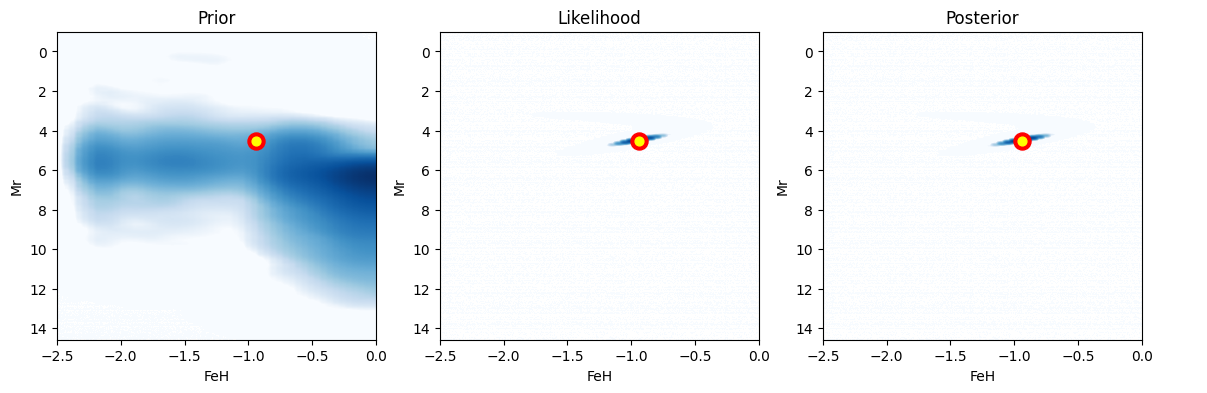

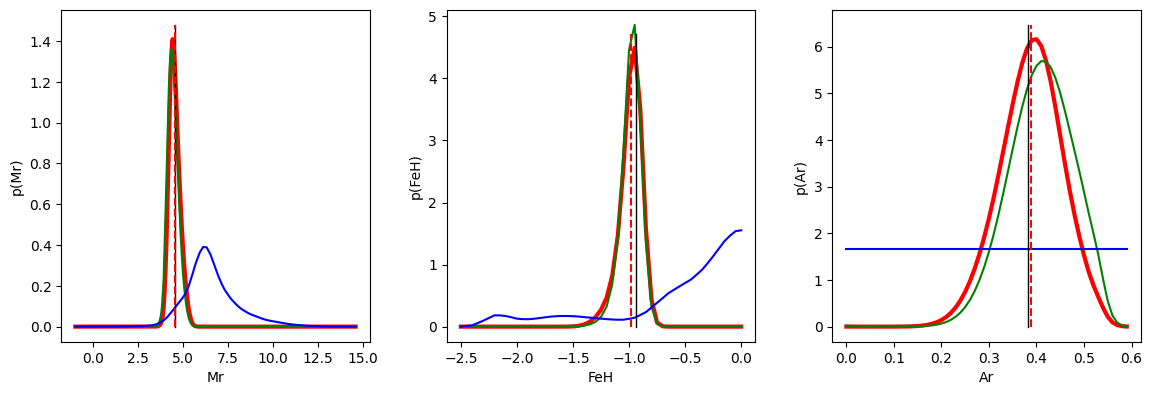

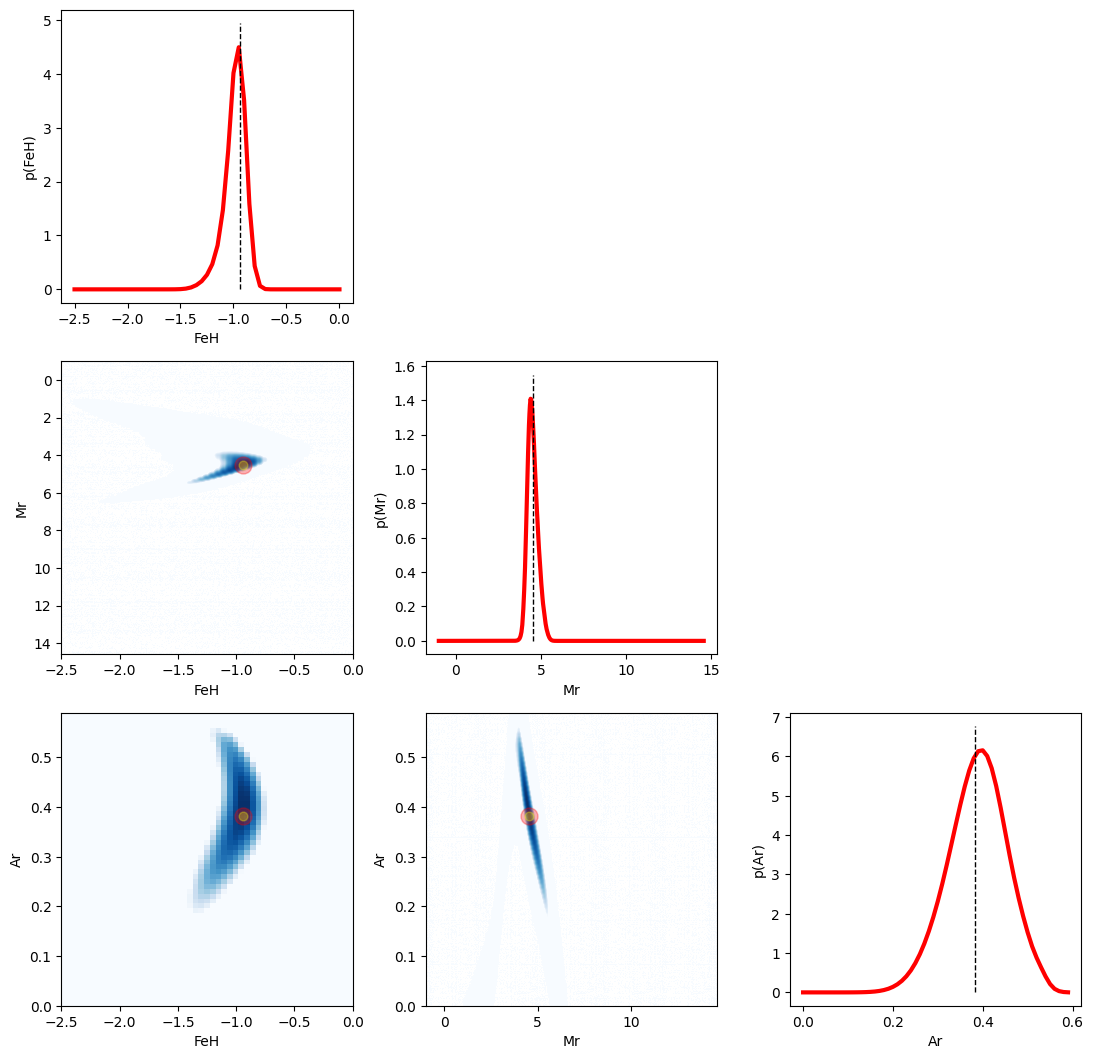

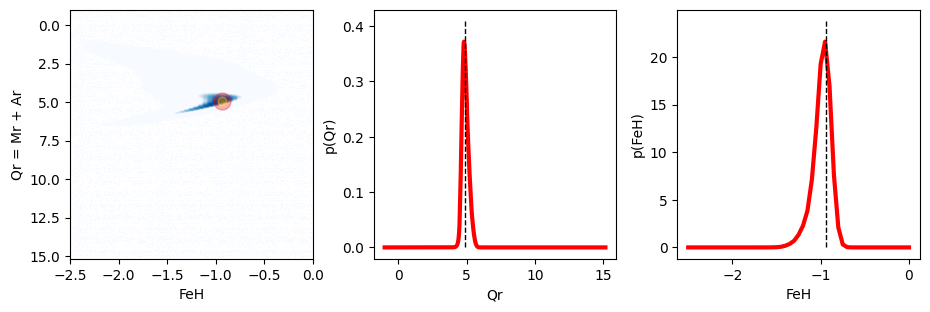

 *** 3D Bayes results for star i= 100592
r mag: 20.38 g-r: 0.474 chi2min: 0.5090055425356427
Mr: true= 4.54 estimate= 4.521871376108832  +-  0.3026720410891106
FeH: true= -0.94 estimate= -0.986832483166063  +-  0.10214606810431864
Ar: true= 0.382 estimate= 0.3888587081030987  +-  0.06578268058436389
Qr: true= 4.922 estimate= 4.915707895576422  +-  0.24185453990297293
Mr drop in entropy: -218.64904733777777
FeH drop in entropy: -38.86723908100885
Ar drop in entropy: -114.92698583999447


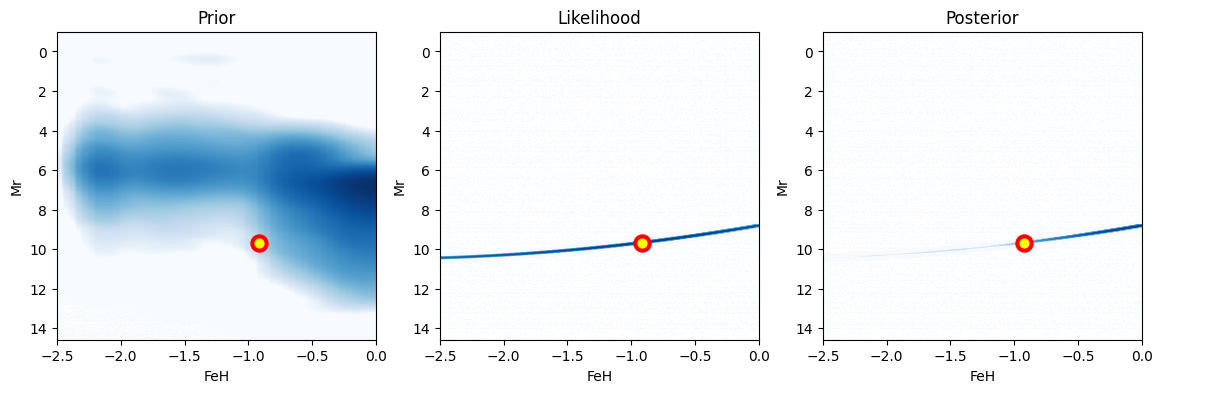

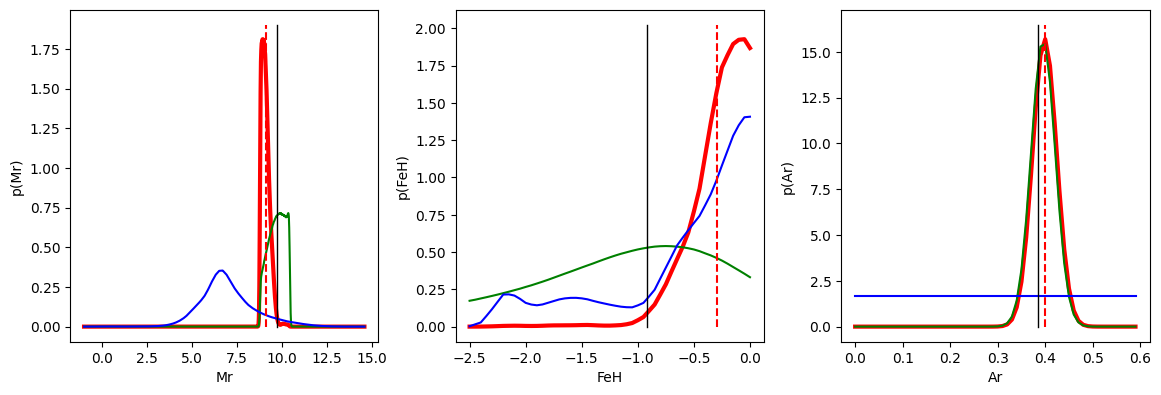

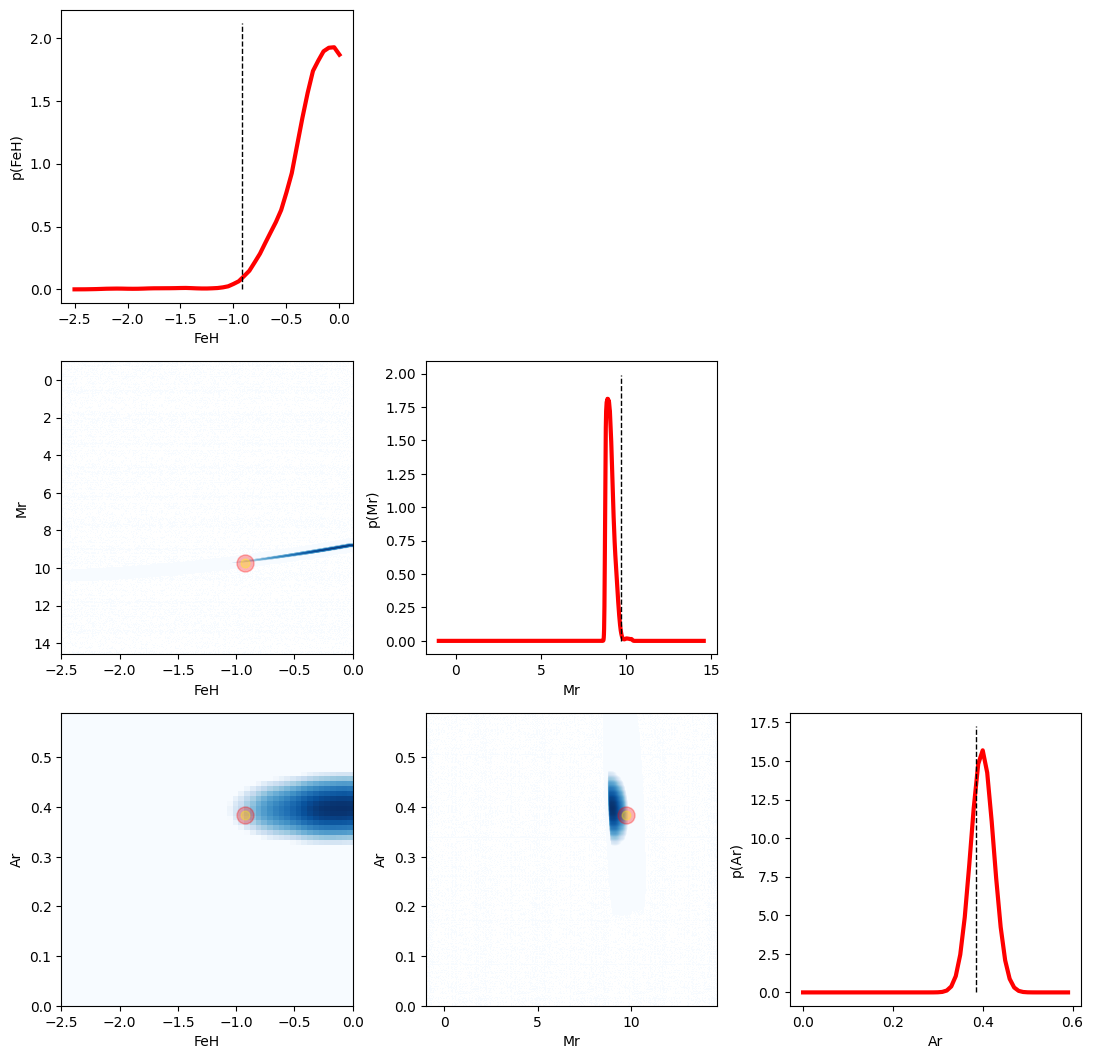

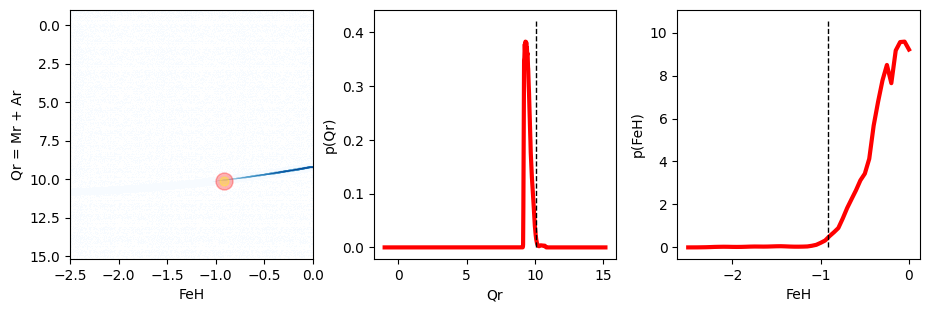

 *** 3D Bayes results for star i= 100593
r mag: 21.09 g-r: 1.545 chi2min: 0.030356405089428162
Mr: true= 9.71 estimate= 9.094859147445888  +-  0.2339839513833631
FeH: true= -0.92 estimate= -0.29178828901468445  +-  0.25439472759377596
Ar: true= 0.384 estimate= 0.3988882404186683  +-  0.025392890687660298
Qr: true= 10.094000000000001 estimate= 9.497027522212642  +-  0.23195998975613233
Mr drop in entropy: -280.93324328931476
FeH drop in entropy: -20.519615810529388
Ar drop in entropy: -251.5385902312709


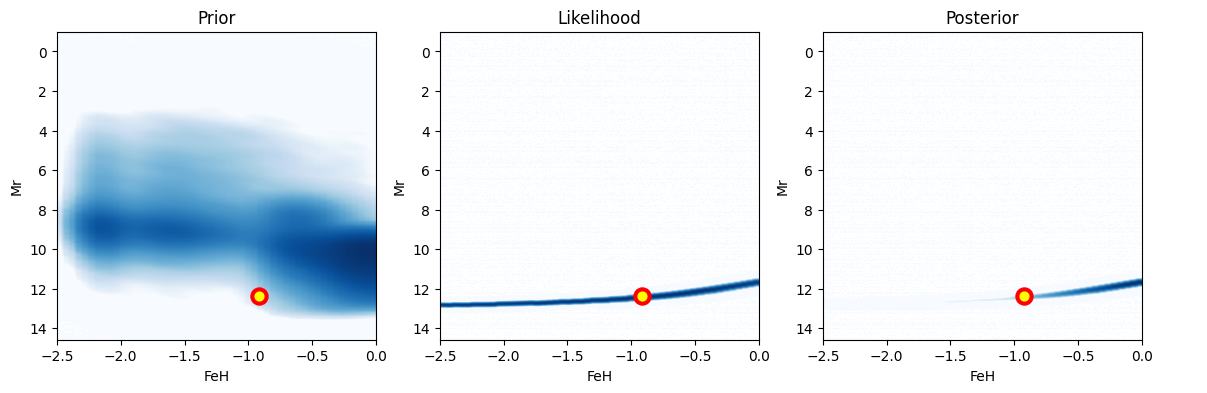

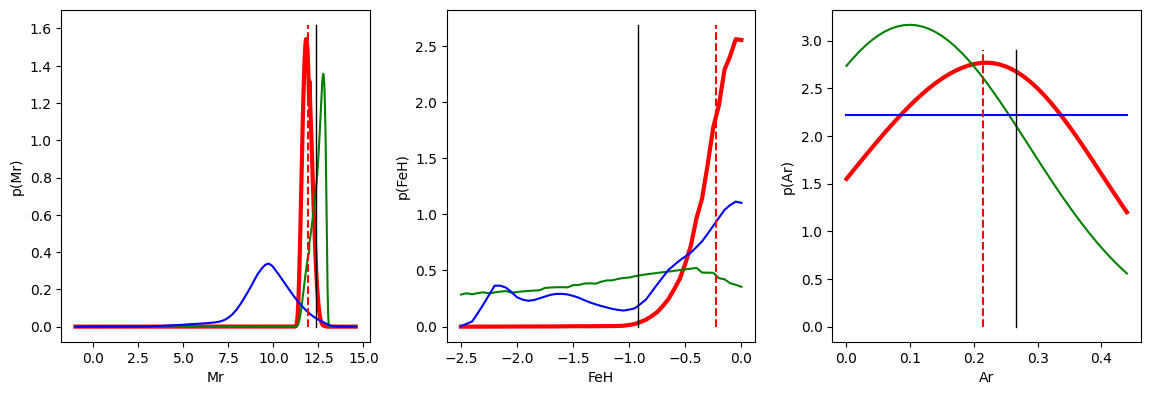

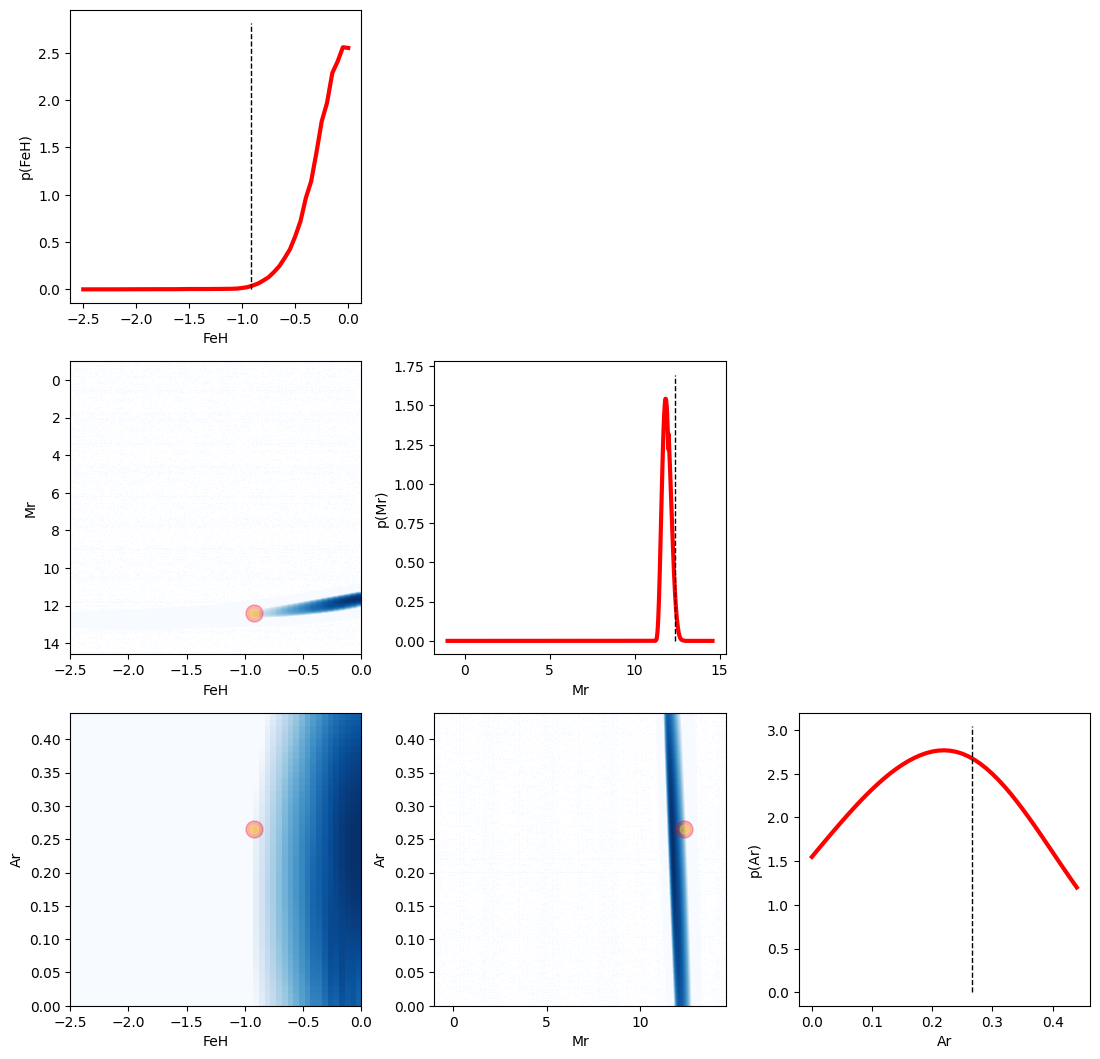

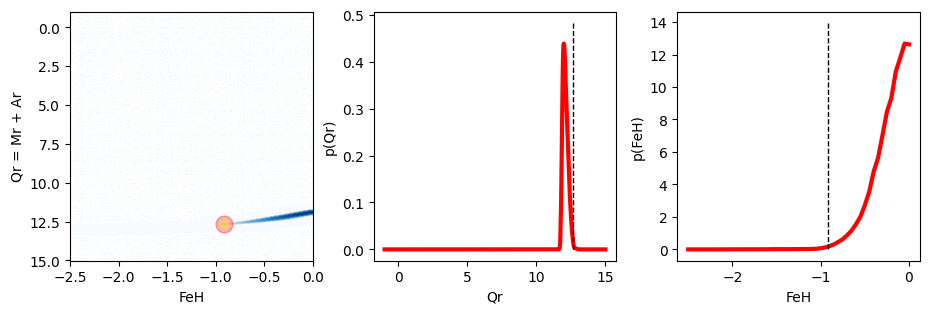

 *** 3D Bayes results for star i= 100594
r mag: 24.09 g-r: 1.48 chi2min: 0.07248140437694849
Mr: true= 12.37 estimate= 11.899533405809454  +-  0.25171701813200276
FeH: true= -0.92 estimate= -0.22402071053418612  +-  0.19922852358814688
Ar: true= 0.266 estimate= 0.21472241550584262  +-  0.11751751332694936
Qr: true= 12.636 estimate= 12.118270959282638  +-  0.19672159960639135
Mr drop in entropy: -247.29361310425304
FeH drop in entropy: -31.984208873390813
Ar drop in entropy: -3.2234602203884037


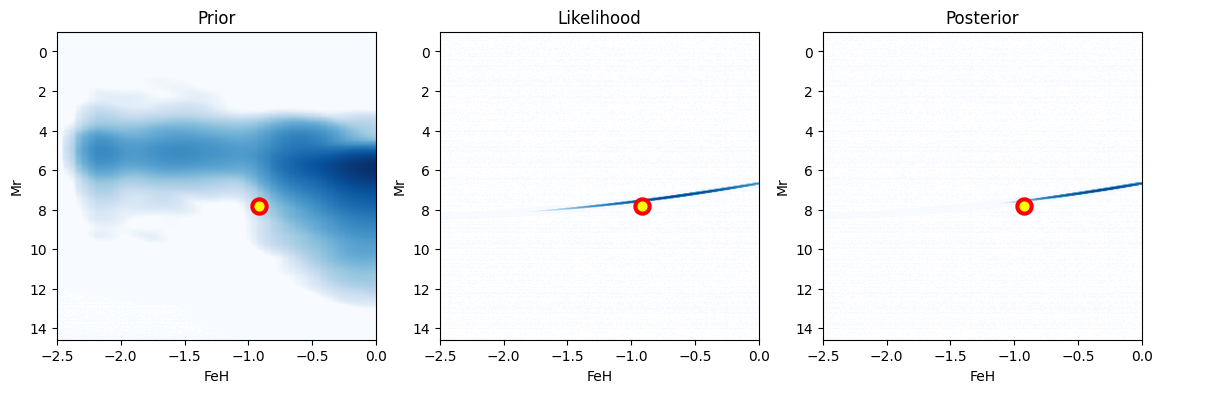

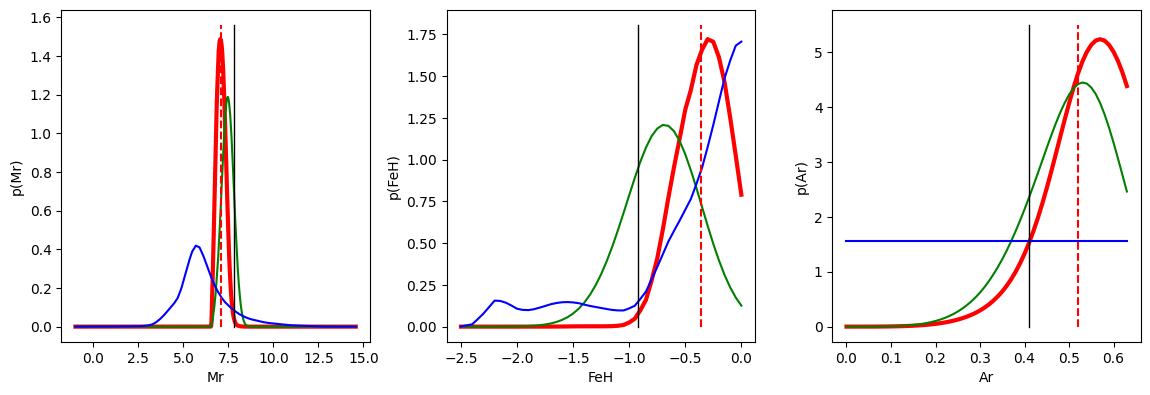

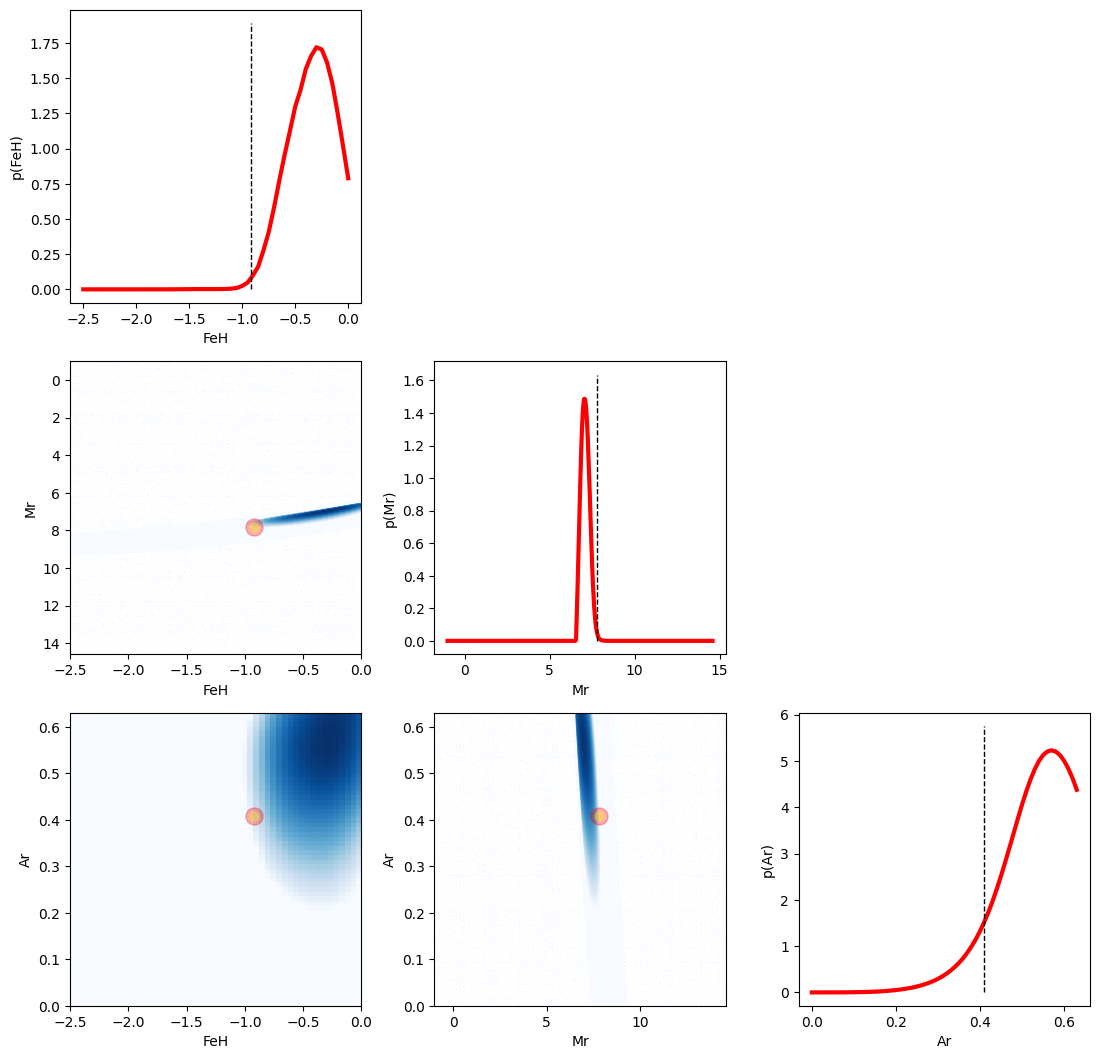

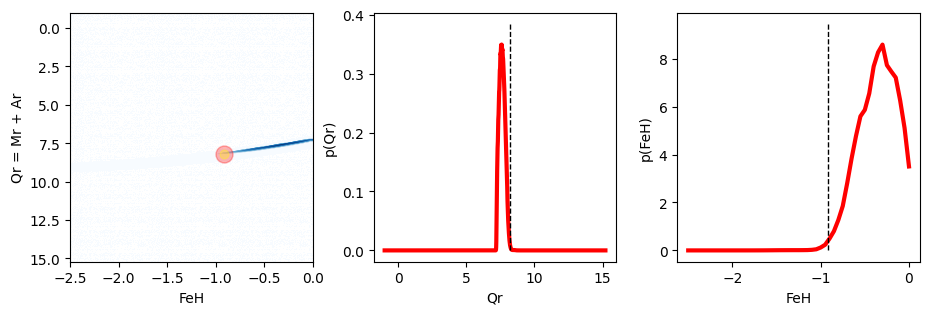

 *** 3D Bayes results for star i= 100595
r mag: 20.06 g-r: 1.293 chi2min: 0.01822700463724963
Mr: true= 7.8 estimate= 7.103934881040151  +-  0.24998842535765067
FeH: true= -0.92 estimate= -0.3561948253759222  +-  0.21482948578722924
Ar: true= 0.409 estimate= 0.5202508327366568  +-  0.08126051990122111
Qr: true= 8.209 estimate= 7.629520684930379  +-  0.21474010601536325
Mr drop in entropy: -237.00035340172545
FeH drop in entropy: -15.002831376645549
Ar drop in entropy: -114.86373277753394


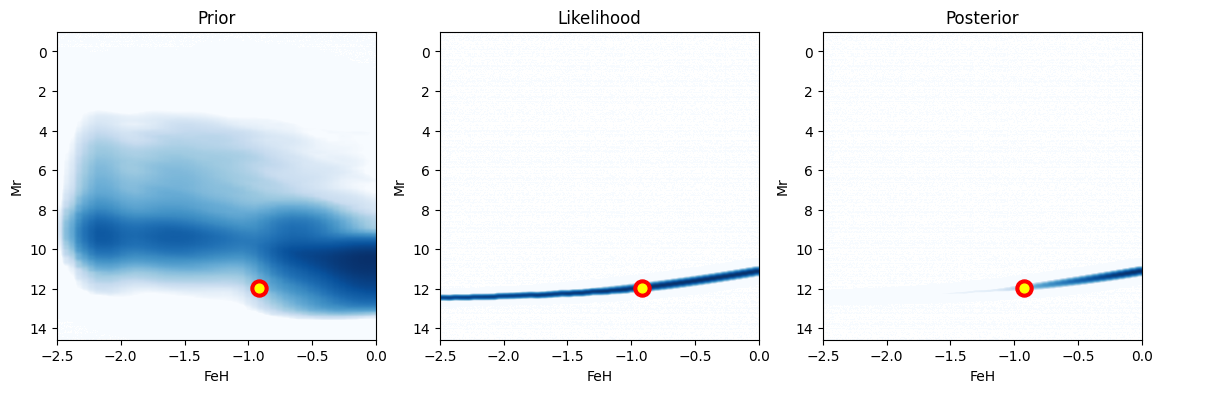

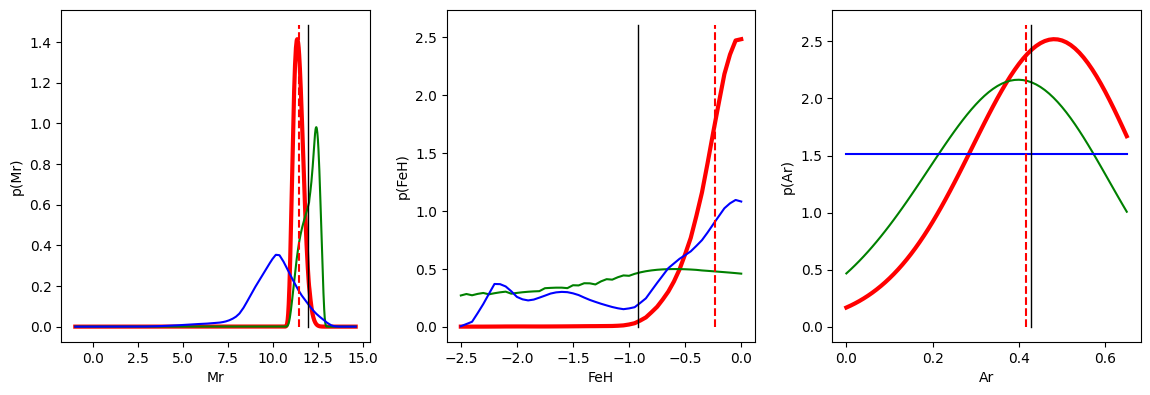

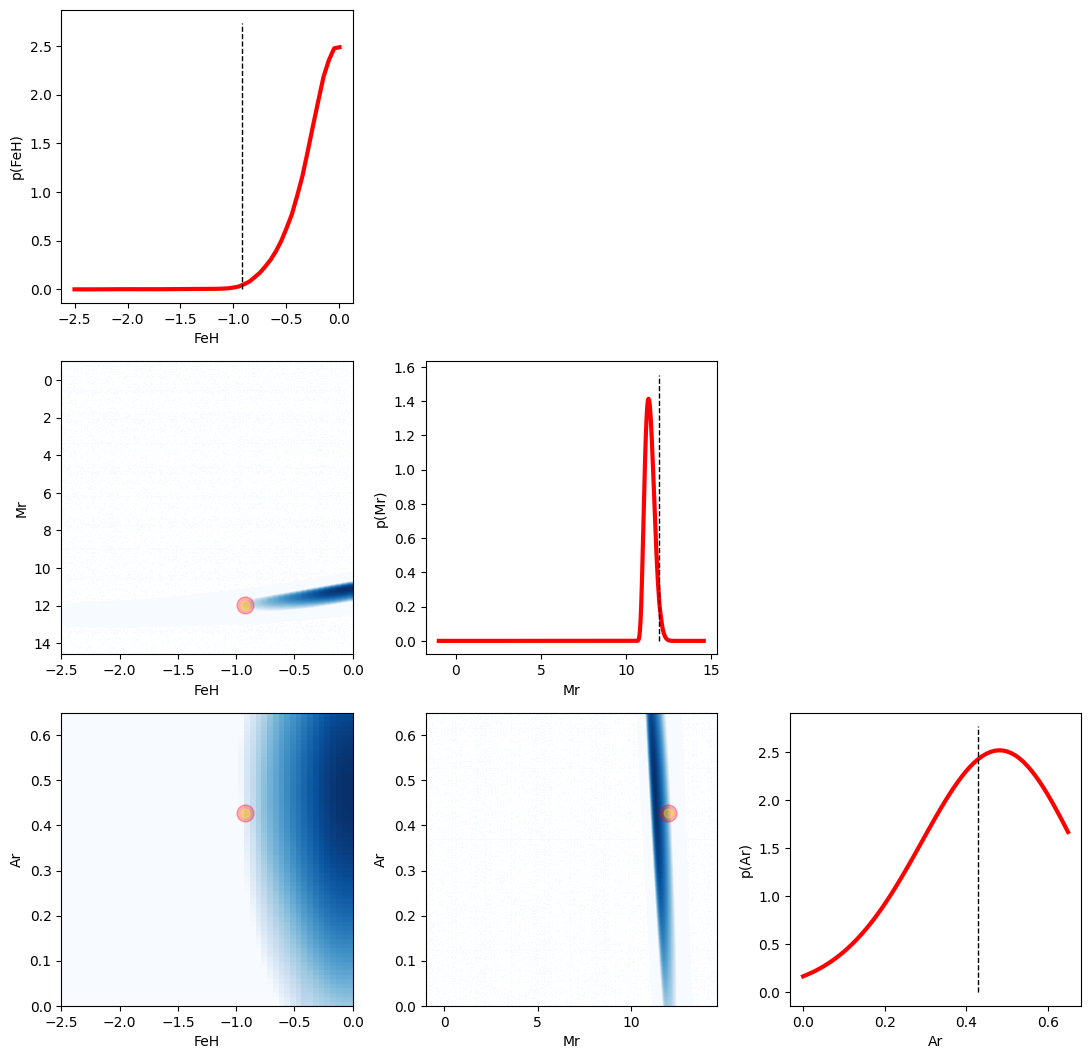

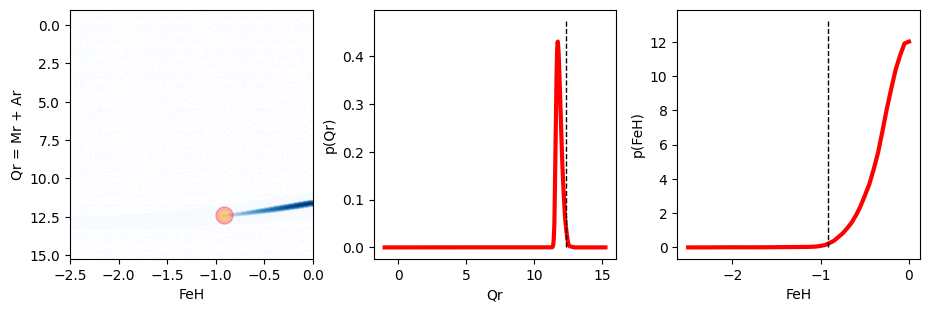

 *** 3D Bayes results for star i= 100596
r mag: 24.34 g-r: 1.574 chi2min: 0.02129620551020014
Mr: true= 11.94 estimate= 11.416471718034023  +-  0.2790196837348285
FeH: true= -0.92 estimate= -0.2360849215326887  +-  0.21017560229398874
Ar: true= 0.428 estimate= 0.41667426592775336  +-  0.1477609929325486
Qr: true= 12.368 estimate= 11.837959156363539  +-  0.2110263728069427
Mr drop in entropy: -227.95283581656165
FeH drop in entropy: -30.83352668417811
Ar drop in entropy: -25.005497282071794
Finished in 96 seconds.


In [114]:
iStart = 1  #  
iEnd = -1    # if <0: do all stars
myStars = [0, 10, 100, 195, 100592, 710592, 1000, 10000]  # for method illustration, make plots for these stars 
myStars = [] # no plots when measuring speed
verb=True

### TESTS (set to False to bypass)
if True: 
    iStart = 100592  # for testing option restrictLocus=True in bt.makeBayesEstimates3D
    iEnd = iStart + 6
    myStars = [100592, 100593, 100594, 100595, 100596] 
    #myStars = [100592] 
    outfile = '../data/simCatalog_three_pix_triout_chiTest4_BayesEstimates3Ddiscard.txt'
    ############

timeStart = !date +%s  
postCube, Mr1d, FeH1d, Ar1d = bt.makeBayesEstimates3D(catalog, fitColors, locusData, locus3DList, ArGridList, priorsRootName, outfile, iStart, iEnd, myStars, verbose=verb)
# 2D version, where prior for Ar is set to the true value for each star
# bt.makeBayesEstimates2D(catalog, fitColors, OKlocus, priorsRootName, outfile, iStart, iEnd, myStars, verbose=False)
timeEnd = !date +%s  
runTime = int(timeEnd[0])-int(timeStart[0])
print('Finished in', runTime, 'seconds.')

In [10]:
# for processed stars
if (iEnd < iStart):
    iStart = 0
    iEnd = np.size(catalog)
simsP = sims[iStart:iEnd]
simsP['dMr'] = simsP['Mr'] - simsP['MrEst']
simsP['dMrNorm'] = simsP['dMr'] / simsP['MrEstUnc'] 
simsP['dFeH'] = simsP['FeH'] - simsP['FeHEst']
simsP['dFeHNorm'] = simsP['dFeH'] / simsP['FeHEstUnc'] 
simsP['dAr'] = simsP['Ar'] - simsP['ArEst']
simsP['dArNorm'] = simsP['dAr'] / simsP['ArEstUnc'] 
print('sample size:', np.size(simsP))
print('Mr  FeH  Ar:')
print('median uncertainty:', np.median(simsP['MrEstUnc']), np.median(simsP['FeHEstUnc']), np.median(simsP['ArEstUnc']))
print('median error:', np.median(simsP['dMr']), np.median(simsP['dFeH']), np.median(simsP['dAr']))
print('std for chi:', np.std(simsP['dMrNorm']), np.std(simsP['dFeHNorm']), np.std(simsP['dArNorm']))

sample size: 2
Mr  FeH  Ar:
median uncertainty: 0.2683279962362368 0.1782703978490473 0.045587785636012096
median error: 0.31663473822264043 -0.2906896139096263 -0.010873474260883503
std for chi: 1.2845460486683866 1.4639611286950618 0.2410260874808426


In [11]:
# SPEED TEST (with all stars):
# 3D finished in 253673 seconds: 0.312 sec/star or 11550 star/hr (or 4 days for a million stars)
# 3D with 10-2 sparse models: 8657 seconds, or ~30 times faster (10 milisec/star)
# 2D: 

In [12]:
### component speed tests: 1000 stars (so sec -> milisec)
# 0) full computation: 161 sec  (3 sec for 2D)
# 1) chi2 computation: 22 sec  
# 2) likeGrid computation: 16 sec (for simple exp computation)
# 3) priors: 15 sec 
# 4) posterior: 7 sec (for posterior = prior * likelihood)
# 5) marginal distributions and stats: 8 sec 
# 6) writing: <1 sec 
# 7) initial pre-loop setup: 4 sec
##
## tests of subsampling: linear scaling with the # of grid points
## kSubsample  makeLocus  total runtime
#    1  1         97          128
#    1  2         47           63
#    2  1         49           64
#    5  1         20           26 
#    5  2          9           14
#   10  2          5            8 

In [13]:
# interesting stars for further investigation and illustration
# i=195 tri-modal posterior for Ar 
# i=100592 nice turn-off with nice parameter covariances - rerun at higher resolution (no subsampling)

In [ ]:
def showQplot(postCube, Mr1d, FeH1d, Ar1d, md, xLab='FeH', yLab='Q', x0=-99, y0=-99, z0=-99, logScale=False, cmap='Blues'):

    def oneImage(ax, image, extent, title, showTrue, x0, y0, origin, logScale=True, cmap='Blues'):
        im = image/image.max()
        if (logScale):
            cmap = ax.imshow(im.T,
               origin=origin, aspect='auto', extent=extent,
               cmap=cmap, norm=LogNorm(im.max()/100, vmax=im.max()))
        else:
            cmap = ax.imshow(im.T, origin='upper', aspect='auto', extent=extent, cmap=cmap)
        ax.set_title(title)
        if (showTrue):
            ax.scatter(x0, y0, s=150, c='red', alpha=0.3) 
            ax.scatter(x0, y0, s=40, c='yellow', alpha=0.3) 
        return cmap

 
    # unpack metadata
    xMin = md[0]  # FeH
    xMax = md[1]
    yMin = md[3]  # Mr
    yMax = md[4]
    zMin = 0      # Ar
    zMax = Ar1d[-1]
       
    #### make 3 marginal (summed) 2-D distributions and 3 1-D marginal distributions 
    # grid steps
    dFeH = FeH1d[1]-FeH1d[0]
    dMr = Mr1d[1]-Mr1d[0]
    dAr = Ar1d[1]-Ar1d[0]
    
    # 1-D marginal distributions
    margMr, margFeH, margAr = getMargDistr3D(postCube, dMr, dFeH, dAr) 

    # 2-D marginal distributions
    # Mr vs. FeH
    im1 = np.sum(postCube, axis=(2))
    # Ar vs. FeH
    im2 = np.sum(postCube, axis=(1))
    # Ar vs. Mr
    im3 = np.sum(postCube, axis=(0))
        
    showTrue = False
    if ((x0>-99)&(y0>-99)):
        showTrue = True
        
    ### plot  
    fig, axs = plt.subplots(3,3,figsize=(12,12))
    fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95, bottom=0.12, top=0.95)

    
    # row 1: marginal FeH
    myExtent=[xMin, xMax, yMin, yMax]
    axs[0,0].plot(FeH1d, margFeH, 'r', lw=3)
    axs[0,0].plot([x0, x0], [0, 1.1*np.max(margFeH)], '--k', lw=1)
    axs[0,0].set(xlabel='FeH', ylabel='p(FeH)')
    axs[0,1].set_axis_off()
    axs[0,2].set_axis_off()
  
    # row 2: im1 and marginal Mr
    myExtent=[xMin, xMax, yMin, yMax]
    cmap = oneImage(axs[1,0], im1, myExtent, '', showTrue, x0, y0, origin='upper', logScale=logScale)
    axs[1,0].set(xlabel='FeH', ylabel='Mr')
    axs[1,1].plot(Mr1d, margMr, 'r', lw=3)
    axs[1,1].plot([y0, y0], [0, 1.1*np.max(margMr)], '--k', lw=1)
    axs[1,1].set(xlabel='Mr', ylabel='p(Mr)')
    axs[1,2].set_axis_off()

    # row 3: im2, im3, and marginal Ar
    myExtent=[xMin, xMax, zMin, zMax]
    cmap = oneImage(axs[2,0], im2, myExtent, '', showTrue, x0, z0, origin='lower', logScale=logScale)
    axs[2,0].set(xlabel='FeH', ylabel='Ar')
    myExtent=[yMax, yMin, zMin, zMax]
    cmap = oneImage(axs[2,1], im3, myExtent, '', showTrue, y0, z0, origin='lower', logScale=logScale)
    axs[2,1].set(xlabel='Mr', ylabel='Ar')
    axs[2,2].plot(Ar1d, margAr, 'r', lw=3)
    axs[2,2].plot([z0, z0], [0, 1.1*np.max(margAr)], '--k', lw=1)
    axs[2,2].set(xlabel='Ar', ylabel='p(Ar)')

    
    cax = fig.add_axes([0.84, 0.1, 0.1, 0.75])
    cax.set_axis_off()
    #cb = fig.colorbar(cmap, ax=cax)
    #if (logScale):
        #cb.set_label("density on log scale")
    #else:
        #cb.set_label("density on linear scale")

    #for ax in axs.flat:
        # ax.set(xlabel=xLab, ylabel=yLab)
        # print('pero')
        
    plt.savefig('../plots/cornerPlot3.png')
    plt.show()
     


In [ ]:
# postCube, Mr1d, FeH1d, Ar1d

In [18]:
print(postCube.shape, FeH1d.shape, Mr1d.shape, Ar1d.shape)

(51, 1559, 60) (51,) (1559,) (60,)


In [102]:
def getQmap(cube, FeH1d, Mr1d, Ar1d):
    Smax = -1
    # interpolate 3D cube(FeH, Mr, Ar) onto Qr=Mr+Ar vs. FeH 2D grid 
    Qmap = 0*cube[:,:,0]
    # Q grid, same size as Mr1d array 
    Qr1d = np.linspace(np.min(Mr1d), (np.max(Ar1d)+np.max(Mr1d)), np.size(Mr1d))
    for i in range(0,np.size(FeH1d)):
        for j in range(0,np.size(Qr1d)):
            # summation
            Ssum = 0.0
            for k in range(0,np.size(Ar1d)):
                Mr = Qr1d[j] - Ar1d[k]
                # now need to get the value of index for this Mr
                jk = np.int((Mr-Mr1d[0])/(Mr1d[1]-Mr1d[0])) 
                if ((jk>=0)&(jk<np.size(Mr1d))):
                    Ssum += cube[i,jk,k]
            Qmap[i,j] = Ssum
    return Qmap, Qr1d

In [103]:
Qmap, Qr1d = getQmap(postCube, FeH1d, Mr1d, Ar1d)

In [104]:
FeHmin = np.min(FeH1d)
FeHmax = np.max(FeH1d)
FeHNpts = FeH1d.size  
QrFaint = np.max(Qr1d)
QrBright = np.min(Qr1d)
QrNpts = Qr1d.size 
mdQ = np.array([FeHmin, FeHmax, FeHNpts, QrFaint, QrBright, QrNpts])

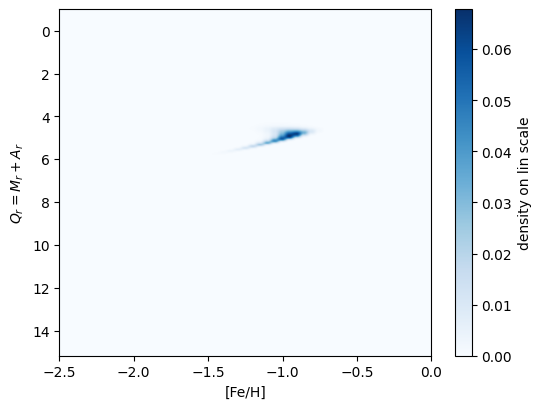

In [105]:
pt.showFlat2Dmap(Qmap, mdQ, xLabel='[Fe/H]', yLabel='$Q_r = M_r + A_r$')